# PAML for dynamic systems:
### Neural ODE and training methods for continuous-time models
Example system: Nonlinear spring pendulum

---

Lecture: "Physics-augmented machine learning" @ Cyber-Physical Simulation, TU Darmstadt

Lecturer: Prof. Oliver Weeger

Author: Fabian J. Roth

---

#### In this notebook, you will...

* learn about the two methods to train continuous-time dynamical ML-models: Derivative and trajectory fitting.
* learn about neural ODEs and use this model to explore the differences between derivative and trajectory fitting.
* use a mixed training strategy to fine tune a neural ODE with trajectory fitting.
* calibrate an augmented neural ODE to learn from partial system states.

#### Contents
1. [Example System: The spring pendulum system](#theory_example_system)<br>
    1.1 [Data generation](#data_generation)<br>
2. [Theory: Neural ODEs and the model training](#theory_node_training)<br>
3. [Task A: Comparing training strategies](#task_a)<br>
4. [Task B: Fine tuning with trajectory fitting](#task_b)<br>
5. [Homework: Augemented Neural ODE](#homework)<br>

# 0. Installation
Run the following code cell to install the required packages. Then **restart your session** to make these packages available.

In [1]:
def is_colab():
    """Determine if the code is running in Google Colab."""
    try:
        import google.colab

        return True
    except ImportError:
        return False


if is_colab():
    print("Running in Google Colab, trying to install LecturePhysicsAwareML...")
    !git clone --depth 1 https://github.com/Drenderer/LecturePhysicsAwareML.git
    %cd LecturePhysicsAwareML/dynamic_modeling
    %pip install -e .
    print(
        "\n************************************************************************************\n\
        Make sure to restart the session after installation (Runtime > Restart Session).\n\
        ********************************************************************************"
    )
else:
    print(
        "Not running in Google Colab. \nPlease install the package manually if needed. If you are using pip, run:\n>>> pip install -e .\nin the dynamic_modeling directory."
    )

Not running in Google Colab. 
Please install the package manually if needed. If you are using pip, run:
>>> pip install -e .
in the dynamic_modeling directory.


In [2]:
from dynamic_modeling import ODESolver, NODEDerivative
from dynamic_modeling.spring_pendulum import (
    SpringPendulum,
    animate_spring_pendulum,
    polar2cartesian,
    plot_trajectory,
    plot_energy
)

import klax

import jax
import jax.random as jr
import jax.numpy as jnp
import optax


import matplotlib.pyplot as plt

# Use jax in float 64 mode (not strictly necessary)
jax.config.update('jax_enable_x64', True)

# Define global keyword arguments for plotting
true_kwargs = dict(color="black", lw=2, marker='o', markevery=20)

# Set the seeds for the random number generator
key = jr.key(0)
mlp_key, loader_key = jr.split(key)

## 1. Example System: The spring pendulum system <a id='theory_example_system'></a>
In this task we consider a nonlinear spring pendulum system:

<img src="images\Spring_pendulum_only_cartesian.png" height="400"/>

The governing equations can be obtained in many ways, here we use [Hamiltons Principle](https://en.wikipedia.org/wiki/Hamilton%27s_principle) and the [Euler-Lagrange equation](https://en.wikipedia.org/wiki/Euler%E2%80%93Lagrange_equation):

Describing position of the mass $m$ with generalized (cartesian) coordinates $q_x, q_y$ and their velocities $\dot q_x, \dot q_y$, the total kinetic energy $T$ and potential energy $U$ are given by
$$
\begin{align}
    T = \frac{1}{2}m \dot q_x^2 + \frac{1}{2}m \dot q_y^2, && U = \frac{1}{2}k\big(\sqrt{q_x^2+q_y^2} - l_0\big)^2 + mgq_y.
\end{align}
$$

where $k$, $l=\sqrt{q_x^2+q_y^2}$ and $l_0$ denote the spring constant, length and rest length respectively, and $g$ is the gravitational constant.

We thus obtain the Lagrangian $\mathcal{L}$:
$$
\begin{align}
    \mathcal{L}(q_x, q_y, \dot q_x, \dot q_y) = T - U = \frac{1}{2}m(\dot q_x^2 + \dot q_y^2) - \left[ \frac{1}{2}k\left(\sqrt{q_x^2 + q_y^2} - l_0\right)^2 + mgq_y \right] + C
\end{align}
$$
where $C$ is an arbitrary constant corresponding to the chosen zero-level of the potential energy.

Applying the [Euler-Lagrange equation](https://en.wikipedia.org/wiki/Euler%E2%80%93Lagrange_equation) results in the following equation of motion:
$$
\begin{align}
0 &= m\ddot q_x + k\left(1 - \frac{l_0}{\sqrt{q_x^2 + q_y^2}}\right)q_x\\
0 &= m\ddot q_y + k\left(1 - \frac{l_0}{\sqrt{q_x^2 + q_y^2}}\right)q_y + mg
\end{align}
$$
This can be written as a first order ordinary differential equation (ODE) by introducing the velocities $v_x = \dot q_x, v_y = \dot q_y$:
$$
\begin{align}
\dot q_x &= v_x\\
\dot q_y &= v_y\\
\dot v_x &= -\frac{k}{m}\left(1 - \frac{l_0}{l(\boldsymbol{q})}\right)q_x\\
\dot v_y &= -\frac{k}{m}\left(1 - \frac{l_0}{l(\boldsymbol{q})}\right)q_y - g
\end{align}
$$

Let's generate some trajectories, using varying initial positions.

## 1.1 Data generation <a id='data_generation'></a>
The following code cells generate and visualize data from the spring pendulum system.

Feel free to change the parameters marked by ``# <<<`` *later* during the tasks.

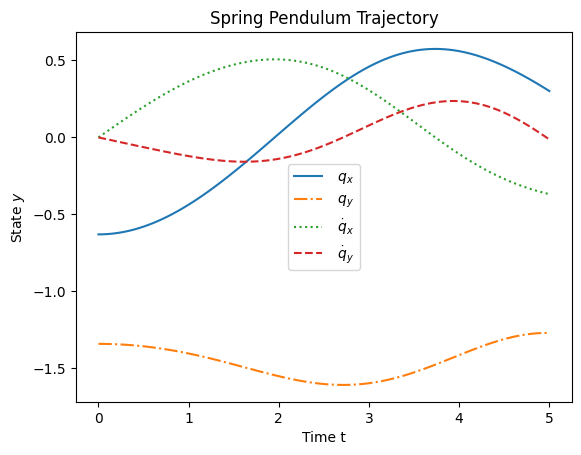

In [3]:
spring_pendulum = SpringPendulum(k=2.0, m=1.0, g=1.0, l0=1.0)
true_system = ODESolver(spring_pendulum)

num_traj = 40           # <<< Number of trajectories
t_max = 5               # <<< Length of trajectories [s]
num_t_samples = 100     # <<< Number of samples per trajectory

key = jr.key(0)
r_key, θ_key = jr.split(key)
ts = jnp.linspace(0, t_max, num_t_samples)

# Generate random initial conditions for training
# Here we use polar coordinates to more easily define reasonable initial conditions.
r0s = jr.uniform(r_key, (num_traj,), minval=0.9, maxval=1.5)
θ0s = jr.uniform(θ_key, (num_traj,), minval=-jnp.pi / 6, maxval=jnp.pi / 6)
y0s_polar = jnp.stack([r0s, θ0s, jnp.zeros((num_traj,)), jnp.zeros((num_traj,))], axis=-1)
y0s = polar2cartesian(y0s_polar)
ys = jax.vmap(true_system, in_axes=(None, 0))(ts, y0s)

# Make derivative data
ys_flat = jnp.reshape(ys, (-1, ys.shape[-1]))
ys_t_flat = jax.vmap(spring_pendulum, (None, 0))(None, ys_flat)

# Plot a sample trajectory
plot_trajectory(ts, ys[0], states="all")
plt.show()

In [ ]:
# Animate all trainig trajectories
animate_spring_pendulum(ts, ys, speedup=5)

## 2. Theory: Neural ODEs and the model training <a id='theory_node_training'></a>

#### Neural ODEs (NODEs)
In this tutorial we consider models of the form 
$$ \dot{\mathbf{y}} = f_{NN}(\mathbf{y}), \qquad \text{with} \;\mathbf{y}=[q_x, q_y, v_x, v_y]^\intercal$$
where the function $f_{NN}: \mathbb{R}^n\mapsto\mathbb{R}^n$ is parameterized by a neural network with parameters $\mathbf{\phi}$. We want to learn these parameters from data. In particular, we consider neural ODEs which simply use a neural network directly as function $f_{NN}(\mathbf{y}) = NN(\mathbf{y}; \mathbf{\phi})$.

#### Training: Derivative vs. Trajectory fitting

When it comes to training such models we have two different options: *Derivative* and *Trajectory* fitting:
1. **Derivative fitting**

  Here we need the data to be given as pairs $(\mathbf{y}, \mathbf{\dot y})$, with $\mathbf{y}\in\mathbb{R}^n$. So for every state of the system $\mathbf{y}$ we have the corresponding change of the state $\mathbf{\dot y}$. We have such data for multiple states forming   our data set: $\{(\mathbf{y}_d, \mathbf{\dot y}_d)\}_{d=0,...,D}$. With this data we can simply train the function $f_{NN}(\mathbf{y}; \mathbf{\phi})$ directly. This is called derivative fitting and  we can use a loss function like this:
  $$L(\mathbf{\phi}) = \frac{1}{D}\sum_{d=1}^D||f_{NN}(\mathbf{y_d}; \mathbf{\phi}) - \mathbf{\dot y_d}||^2$$

2. **Trajectory fitting**

  Most of the time we have data in the form of trajectories, meaning that we have a list of states with corresponding timestamps: $\{(t_k, \mathbf{y}_k)\}_{k=0,...,K}$. Here $k$ is the index of the timestamp. Most of the time these timestamps are equidistant, but this is not required. Such data is commonly obtained via measurements or simulations. Usually we also have multiple trajectories, which we index by $d$: $\{\{(t_k^d, \mathbf{y}_k^d)\}_{k=0,...,K}\}_{d=0,...,D}$.

  Because we don't have access to the derivatives $\mathbf{\dot y}$ directly, we first need to integrate our model to obtain a trajectory prediction: 
  $$\tilde{\mathbf{y}}_k^d(\mathbf{\phi}) = \int_{t_0}^{t_k}f_{NN}(\mathbf{y(t)}; \mathbf{\phi})dt, \quad \mathbf{y(0)} = \mathbf{y_0^d}$$
  We can now compare this predicted trajectory with the given data and formulate a loss like this:
  $$L(\mathbf{\phi}) = \frac{1}{D}\sum_{d=1}^D \frac{1}{K}\sum_{k=1}^K||\tilde{\mathbf{y}}_k^d(\mathbf{\phi}) - \mathbf{y}_k^d||^2$$

In the following code cell we define the loss functions for derivative and trajectory fitting.

In [4]:
# Define the loss functions for derivative and trajectory fitting

def derivative_loss(model: ODESolver, data, batch_axis):
    """Evaluate the models derivative function and compare it to the true derivative."""
    ys, ys_t = data
    ys_t_pred = jax.vmap(model.func, in_axes=batch_axis)(None, ys)
    return jnp.mean(jnp.square(ys_t_pred - ys_t))


def trajectory_loss(model: ODESolver, data, batch_axis):
    """Compute the models predicted trajectory and compare it to the true trajectory."""
    ts, ys = data
    ys_pred = jax.vmap(model, in_axes=batch_axis)(ts, ys[:, 0])
    return jnp.mean(jnp.square(ys_pred - ys))


## 3 Task A: Comparing training strategies <a id='task_a'></a>

Before running the code: Feel free to change some parameters of the data generation process above (e.g. ``t_max``) or the parameters of the neural ODE below. Parameters you can change are marked with comments like this: ``# <<<``.

With a partner (one person does (a) the other (b)) run the code in the cells below:

a) Derivative fitting (DF)

b) Trajectory fitting (TF)

and then plot the NODE prediction(s) (3rd code cell below). Consider the following questions:

1) What differences between the training strategies do you observe?

2) Would it make sense to choose the activation ``relu`` for the NODEs NN?

3) Pay particular attention to *extrapolation* in time by evaluating the models on time series that extend beyond the duration of the training data. What do you observe?

In [ ]:
# Derivative fitting (DF)
node_deriv = NODEDerivative(
    hidden_layer_sizes=[16, 16],    # <<< NN size
    activation="softplus",          # <<< Activation function "softplus", "relu" or "sigmoid"
    key=mlp_key
)
node_df = ODESolver(node_deriv)
node_df, hist = klax.fit(
    node_df,
    (ys_flat, ys_t_flat),
    batch_size=32,
    steps=25_000,
    loss_fn=derivative_loss,
    key=loader_key,
)
hist.plot()

In [ ]:
# Trajectory fitting (TF)
node_deriv = NODEDerivative(
    hidden_layer_sizes=[16, 16],    # <<< NN size
    activation="softplus",          # <<< Activation function "softplus", "relu" or "sigmoid"
    key=mlp_key
)
node_tf = ODESolver(node_deriv)

node_tf, hist = klax.fit(
    node_tf,
    (ts, ys),
    batch_axis=(None, 0),
    batch_size=16,
    steps=10_000,
    loss_fn=trajectory_loss,
    key=loader_key,
)
hist.plot()

In [ ]:
# Plot the NODE prediction(s)
y0_eval = jnp.array([0.7, -1.2, 0.0, 0.0])  # <<< Initial condition for evaluation, with [q_x, q_y, v_x, v_y]
t_max_eval = 20                             # <<< Length of evaluation trajectory [s], choose larger values to test extrapolation in time
states = "positions"                        # <<< Plot only: "positions", "velocities" or "all"
ts_eval = jnp.linspace(0, t_max_eval, 1000)


fig, axes = plt.subplots(2, 1, figsize=(15, 8))
ys_true = true_system(ts_eval, y0_eval)
plot_trajectory(ts_eval, ys_true, ax=axes[0], label="True State", states=states, **true_kwargs)
E_true = jax.vmap(spring_pendulum.get_energy)(ys_true)
plot_energy(ts_eval, E_true, ax=axes[1], label="True Energy", **true_kwargs)   # type: ignore
try:
    ys_pred_df = node_df(ts_eval, y0_eval)
    plot_trajectory(ts_eval, ys_pred_df, ax=axes[0], states=states, color="red", label="Predicted (DF)")
    E_pred_df = jax.vmap(spring_pendulum.get_energy)(ys_pred_df)
    plot_energy(ts_eval, E_pred_df, ax=axes[1], color="red", label="Energy of prediction (DF)")   # type: ignore
except NameError:
    print("You have not trained ys_pred_df (derivative fitting). Skipping this model.")
try:
    ys_pred_tf = node_tf(ts_eval, y0_eval)
    plot_trajectory(ts_eval, ys_pred_tf, ax=axes[0], states=states, color="green", label="Predicted (TF)")
    E_pred_tf = jax.vmap(spring_pendulum.get_energy)(ys_pred_tf)
    plot_energy(ts_eval, E_pred_tf, ax=axes[1], color="green", label="Energy of prediction (TF)")   # type: ignore
except NameError:
    print("You have not trained ys_pred_tf (trajectory fitting). Skipping this model.")
plt.tight_layout()
plt.show()

In [ ]:
# Animate the true solution (blue) and the models solution (gray)
_prediction = ys_pred_df    # <<< Put the model you've trained here to view it animated (ys_pred_df or ys_pred_tf)
_temp = jnp.stack([ys_true, _prediction], axis=0)
animate_spring_pendulum(ts_eval, _temp, speedup=5)

## 4 Task B: Fine tuning with trajectory fitting <a id='task_b'></a>

The predictions from the previous task might not be satisfactory. Here we try to improve upon the results by using longer trajectories and trajectory fitting to fine tune a model.

Run the following code to train a neural ODE in two steps:
- Using derivative fitting with the original data
- Continue training the neural ODE by trajectory fitting to longer trajectories.

While the models train, consider the following (alone or with a partner):

1) How to you expect the results to differ from the previous task, after fine-tuning?

2) Explain why you hold these expectations.

After the model trained:

3) Look at the resulting predictions. Do they improve upon the results from the previous task. If so, in which way?

4) In theory, could the same results be obtained by using only trajectory fitting with the longer trajectories? What is the purpose of the derivative fitting here?


In [5]:
# Generate longer trajectories for fine tuning.

num_traj = 40           # <<< Number of trajectories
t_max = 20              # <<< Length of trajectories [s]
num_t_samples = 200     # <<< Number of samples per trajectory

key = jr.key(0)
r_key, θ_key = jr.split(key)
ts_tune = jnp.linspace(0, t_max, num_t_samples)

# Generate random initial conditions for training
r0s = jr.uniform(r_key, (num_traj,), minval=0.9, maxval=1.5)
θ0s = jr.uniform(θ_key, (num_traj,), minval=-jnp.pi / 6, maxval=jnp.pi / 6)
y0s_polar = jnp.stack([r0s, θ0s, jnp.zeros((num_traj,)), jnp.zeros((num_traj,))], axis=-1)
y0s_tune = polar2cartesian(y0s_polar)
ys_tune = jax.vmap(true_system, in_axes=(None, 0))(ts_tune, y0s_tune)

In [ ]:
# Optional: Animate the longer trajectories
animate_spring_pendulum(ts_tune, ys_tune)

In [8]:
node_deriv = NODEDerivative(
    hidden_layer_sizes=[16, 16],
    activation="softplus",
    key=mlp_key
)
node_tuned = ODESolver(node_deriv)

# Start with derivative fitting (DF)
node_tuned, hist = klax.fit(
    node_tuned,
    (ys_flat, ys_t_flat),   # Use the old data
    batch_size=32,
    steps=25_000,
    loss_fn=derivative_loss,
    key=loader_key,
)

# Continue with trajectory fitting (TF)
node_tuned, hist = klax.fit(
    node_tuned,
    (ts_tune, ys_tune),     # Use the tuneing data for TF
    batch_axis=(None, 0),
    batch_size=16,
    steps=2_000,
    loss_fn=trajectory_loss,
    key=loader_key,
)

Step: 0, Loss: 1.323e-01
Step: 100, Loss: 9.820e-02
Step: 200, Loss: 8.995e-02
Step: 300, Loss: 7.713e-02
Step: 400, Loss: 6.449e-02
Step: 500, Loss: 5.440e-02
Step: 600, Loss: 4.238e-02
Step: 700, Loss: 2.725e-02
Step: 800, Loss: 1.434e-02
Step: 900, Loss: 6.083e-03
Step: 1000, Loss: 2.633e-03
Step: 1100, Loss: 1.952e-03
Step: 1200, Loss: 1.825e-03
Step: 1300, Loss: 1.773e-03
Step: 1400, Loss: 1.698e-03
Step: 1500, Loss: 1.683e-03
Step: 1600, Loss: 1.746e-03
Step: 1700, Loss: 1.585e-03
Step: 1800, Loss: 1.573e-03
Step: 1900, Loss: 1.546e-03
Step: 2000, Loss: 1.496e-03
Step: 2100, Loss: 1.466e-03
Step: 2200, Loss: 1.427e-03
Step: 2300, Loss: 1.470e-03
Step: 2400, Loss: 1.388e-03
Step: 2500, Loss: 1.379e-03
Step: 2600, Loss: 1.357e-03
Step: 2700, Loss: 1.415e-03
Step: 2800, Loss: 1.306e-03
Step: 2900, Loss: 1.283e-03
Step: 3000, Loss: 1.344e-03
Step: 3100, Loss: 1.255e-03
Step: 3200, Loss: 1.246e-03
Step: 3300, Loss: 1.250e-03
Step: 3400, Loss: 1.232e-03
Step: 3500, Loss: 1.168e-03
Step

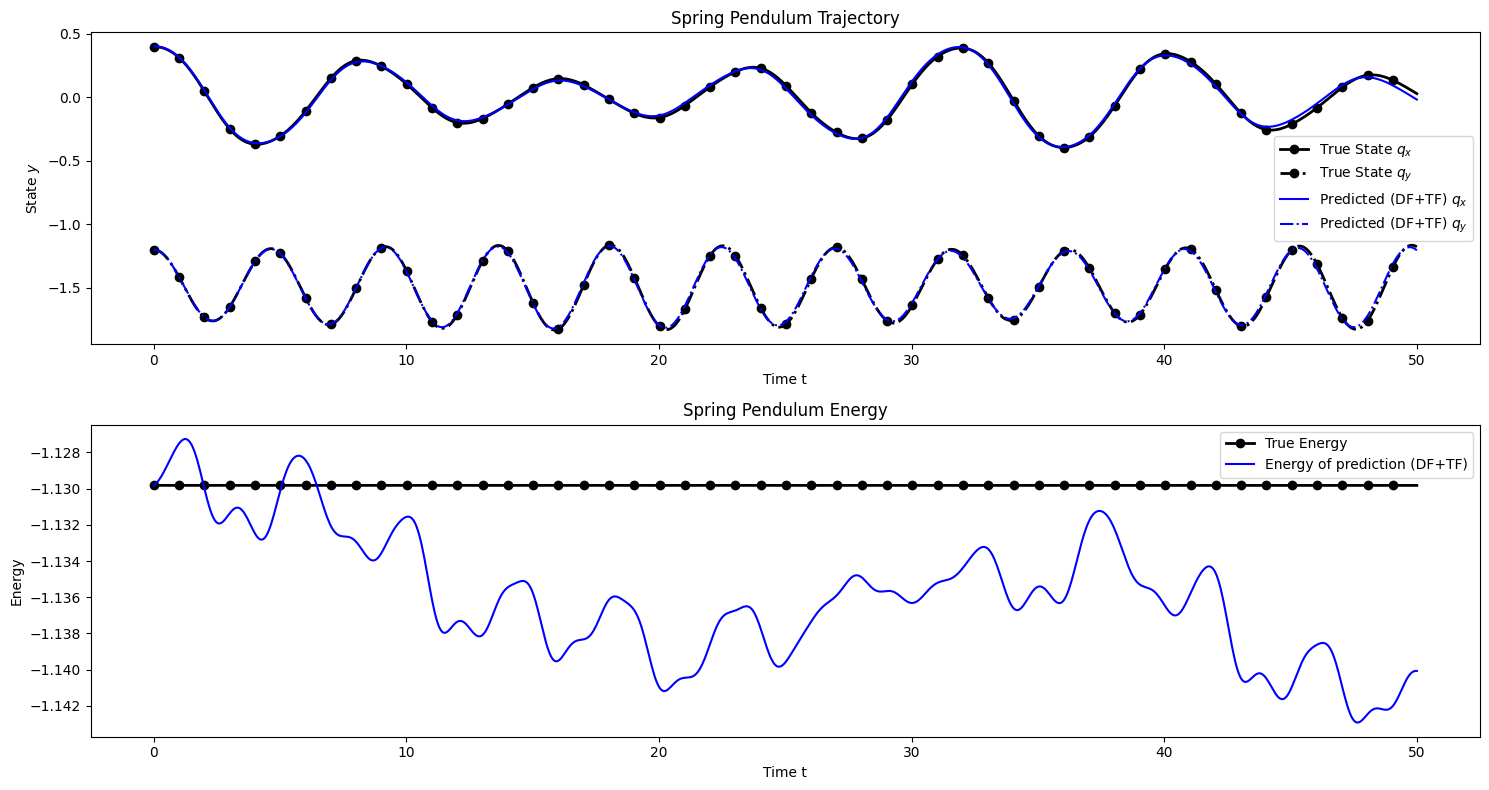

In [9]:
## Plot the NODE prediction(s)

y0_eval = jnp.array([0.4, -1.2, 0.0, 0.0])  # <<< Initial condition for evaluation, with [q_x, q_y, v_x, v_y]
t_max_eval = 50                             # <<< Length of evaluation trajectory
states = "positions"                        # <<< Plot only: "positions", "velocities" or "all"

ts_eval = jnp.linspace(0, t_max_eval, 1000)

# Compute the true and predicted trajectories
ys_true = true_system(ts_eval, y0_eval)
ys_pred_tuned = node_tuned(ts_eval, y0_eval)

# Compute the energies of the states
E_true = jax.vmap(spring_pendulum.get_energy)(ys_true)
E_predicted_df = jax.vmap(spring_pendulum.get_energy)(ys_pred_tuned)

# Plot
fig, axes = plt.subplots(2, 1, figsize=(15, 8))
plot_trajectory(ts_eval, ys_true, ax=axes[0], states=states, label="True State", **true_kwargs)    # type: ignore
plot_energy(ts_eval, E_true, ax=axes[1], label="True Energy", **true_kwargs)   # type: ignore

plot_trajectory(ts_eval, ys_pred_tuned, ax=axes[0], states=states, color="blue", label="Predicted (DF+TF)")
plot_energy(ts_eval, E_predicted_df, ax=axes[1], color="blue", label="Energy of prediction (DF+TF)")   # type: ignore

plt.tight_layout()
plt.show()

In [ ]:
# Animate the true solution (blue) and the models solution (gray)
temp = jnp.stack([ys_true, ys_pred_tuned], axis=0)
animate_spring_pendulum(ts_eval, temp, speedup=5)

## 5 Homework: Augemented Neural ODE <a id='homework'></a>
So far we have used training data of the full state $\mathbf{y}=[q_x, q_y, v_x, v_y]^\intercal$. However, in practice we often don't have the velocities $v_i$ available. Furthermore, when we use ML approaches to learn the dynamics of complex systems, then we often only have a subset of the full system state available. To simulate such a situation the following task assumes that only the positions (but not the velocities) are available in the training data. 

1) Run the following code. It generates truncated data and trains a neural ODE with a two-dimensional state vector $\mathbf{y}=[q_x, q_y]^\intercal$. Can the neural ODE learn the dynamics of the pendulum using only a two dimensional state vector? Explain the results.

It is possible to "artificially" increase the dimensionality of the neural ODE's state vector, to make it larger than the data's state size. For this we add so calld augmented states/dimensions to the state vector:
$$\mathbf{y} = \begin{bmatrix} \mathbf{y}_{data}\\\mathbf{y}_{augmented} \end{bmatrix}$$
We then only use $\mathbf{y}_{data}$ to calculate the loss. The augmented states provide more flexibility to our model that it can use to learn more complicated dynamics.

2) Is it possible to use derivative fitting when using augmented states? Explain.

3) How many augmented states are necessary (in theory) for the model to be able to learn the spring pendulum dynamics? Change the line marked with ``# <<< Number of augmented states...`` and train the model again. What do you observe?

Note: To achieve good results you might need to train the models for a long time (~30-60 min). So go grab a coffee or something while waiting for the training results :)

In [57]:
spring_pendulum = SpringPendulum(k=2.0, m=1.0, g=1.0, l0=1.0)
true_system = ODESolver(spring_pendulum)

n = 40      # Number of trajectories
t_max = 10  # Length of trajectories [s]
num_t_samples = 200     # <<< Number of samples per trajectory

key = jr.key(0)
r_key, θ_key = jr.split(key)
ts = jnp.linspace(0, t_max, num_t_samples)

# Generate random initial conditions for training
# Here we use polar coordinates to more easily define reasonable initial conditions.
r0s = jr.uniform(r_key, (n,), minval=0.9, maxval=1.5)
θ0s = jr.uniform(θ_key, (n,), minval=-jnp.pi / 6, maxval=jnp.pi / 6)
y0s = jnp.stack([r0s, θ0s, jnp.zeros((n,)), jnp.zeros((n,))], axis=-1)
y0s = polar2cartesian(y0s)
ys = jax.vmap(true_system, in_axes=(None, 0))(ts, y0s)

In [ ]:
# Remove the velocities from the training data
ys_truncated = ys[:, :, :2] # Use only the first two states.
print(f"Training data shape (number of trajectories, number of timestamps per trajectory, number of states)={ys_truncated.shape}.")

In [ ]:
num_data_states = ys_truncated.shape[-1]
num_augmented_states = 0    # <<< Number of augmented states that are added to the data states
num_total_states = num_data_states + num_augmented_states
print(f"Total number of states: {num_total_states}.")

node_deriv = NODEDerivative(
    state_size=num_total_states,
    key=mlp_key
)
augmented_node = ODESolver(
    node_deriv, 
    augmentation=num_augmented_states    # Add to augmented states to the model
) 

def trajectory_loss(model: ODESolver, data, batch_axis):
    """Compute the models predicted trajectory and compare it to the true trajectory."""
    ts, ys = data
    ys_pred = jax.vmap(model, in_axes=batch_axis)(ts, ys[:, 0])
    return jnp.mean(jnp.square(ys_pred - ys))

augmented_node, hist = klax.fit(
    augmented_node,
    (ts, ys_truncated),
    batch_axis=(None, 0),
    steps=50_000,
    loss_fn=trajectory_loss,
    optimizer=optax.adam(4e-4),
    key=loader_key,
)
hist.plot()

In [ ]:
## Plot the NODE prediction(s)

y0_eval = jnp.array([0.2, -1.2, 0.0, 0.0])  # <<< Initial condition for evaluation
t_max_eval = 10                             # <<< Length of evaluation trajectory
ts_eval = jnp.linspace(0, t_max_eval, 1000)

# Compute the true and predicted trajectories
ys_true = true_system(ts_eval, y0_eval)
ys_pred_augmented = augmented_node(ts_eval, y0_eval[:2])

# Compute the energies of the states
E_true = jax.vmap(spring_pendulum.get_energy)(ys_true)

# Plot
fig, ax = plt.subplots(figsize=(15, 4))
plot_trajectory(ts_eval, ys_true, label="True State", **true_kwargs)    # type: ignore
plot_trajectory(ts_eval, ys_pred_augmented, color="blue", label="Predicted (augmented NODE)")

plt.tight_layout()
plt.show()